# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [115]:
%matplotlib inline

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from IPython.display import display
from sklearn.ensemble import VotingClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline


import matplotlib.cm as cm

Load feature names.

In [2]:
feature_names = []
with open('../Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [3]:
X, Y = [], []

with open('../Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(7000, 126) (1124, 126)


In [4]:
#Convert data to dataframes
train_data_df = pd.DataFrame(train_data, columns = feature_names)
test_data_df = pd.DataFrame(test_data, columns = feature_names)

train_labels_df = pd.DataFrame(train_labels)
test_labels_df = pd.DataFrame(test_labels)

train_data_df.head()

,cap-shape=bell,cap-shape=conical,cap-shape=convex,cap-shape=flat,cap-shape=knobbed,cap-shape=sunken,cap-surface=fibrous,cap-surface=grooves,cap-surface=scaly,cap-surface=smooth,...,population=scattered,population=several,population=solitary,habitat=grasses,habitat=leaves,habitat=meadows,habitat=paths,habitat=urban,habitat=waste,habitat=woods
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

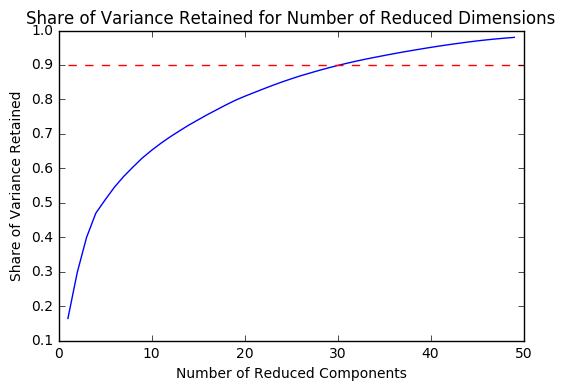

In [5]:
def P1():
### STUDENT START ###
#Plot the total variance that results from reducing to n dimensions
    n_comps_to_try = np.arange(1,50).tolist()

    #calculate the total variance in the untransformed data
    train_covar = train_data_df.cov()
    total_var = np.trace(train_covar)

    #instantiate a list object to hold the total variances
    total_variances = []

    #loop through the number of components to get total variances
    for n_comp in n_comps_to_try:

        pca = PCA(n_components = n_comp)

        #fit and transform  the training data
        train_transformed_reduced = pd.DataFrame(pca.fit_transform(train_data_df))

        #get the total variance
        reduced_dim_covar = train_transformed_reduced.cov()
        new_total_var = np.trace(reduced_dim_covar)

        #append to list
        total_variances.append(new_total_var / total_var)

    #plot the share of retained variance given the number of dimensions we want to reduce to
    plt.figure()
    plt.plot(n_comps_to_try, total_variances)
    plt.title("Share of Variance Retained for Number of Reduced Dimensions")
    plt.xlabel("Number of Reduced Components")
    plt.ylabel("Share of Variance Retained")
    plt.plot((1, 50), (0.9, 0.9), color = "red", linestyle = '--')
    plt.show()
### STUDENT END ###

P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

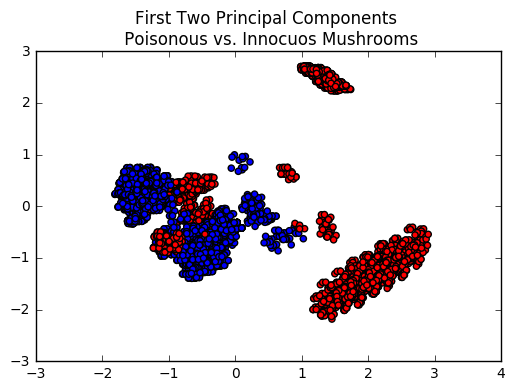

In [6]:
def P2():
### STUDENT START ###
    #instantiate PCA object that reduces to 2 dimensions
    pca_2dim = PCA(n_components = 2)

    #transform the training data
    train_data_2dim_reduced = pd.DataFrame(pca_2dim.fit_transform(train_data))

    #set color map
    colors = {0:"blue", 1:"red"}

    #Plot the results
    plt.figure()
    plt.title("First Two Principal Components \n Poisonous vs. Innocuos Mushrooms")
    plt.scatter(train_data_2dim_reduced[0], train_data_2dim_reduced[1], c = train_labels_df[0].apply(lambda x: colors[x]))
    plt.show()

### STUDENT END ###

P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

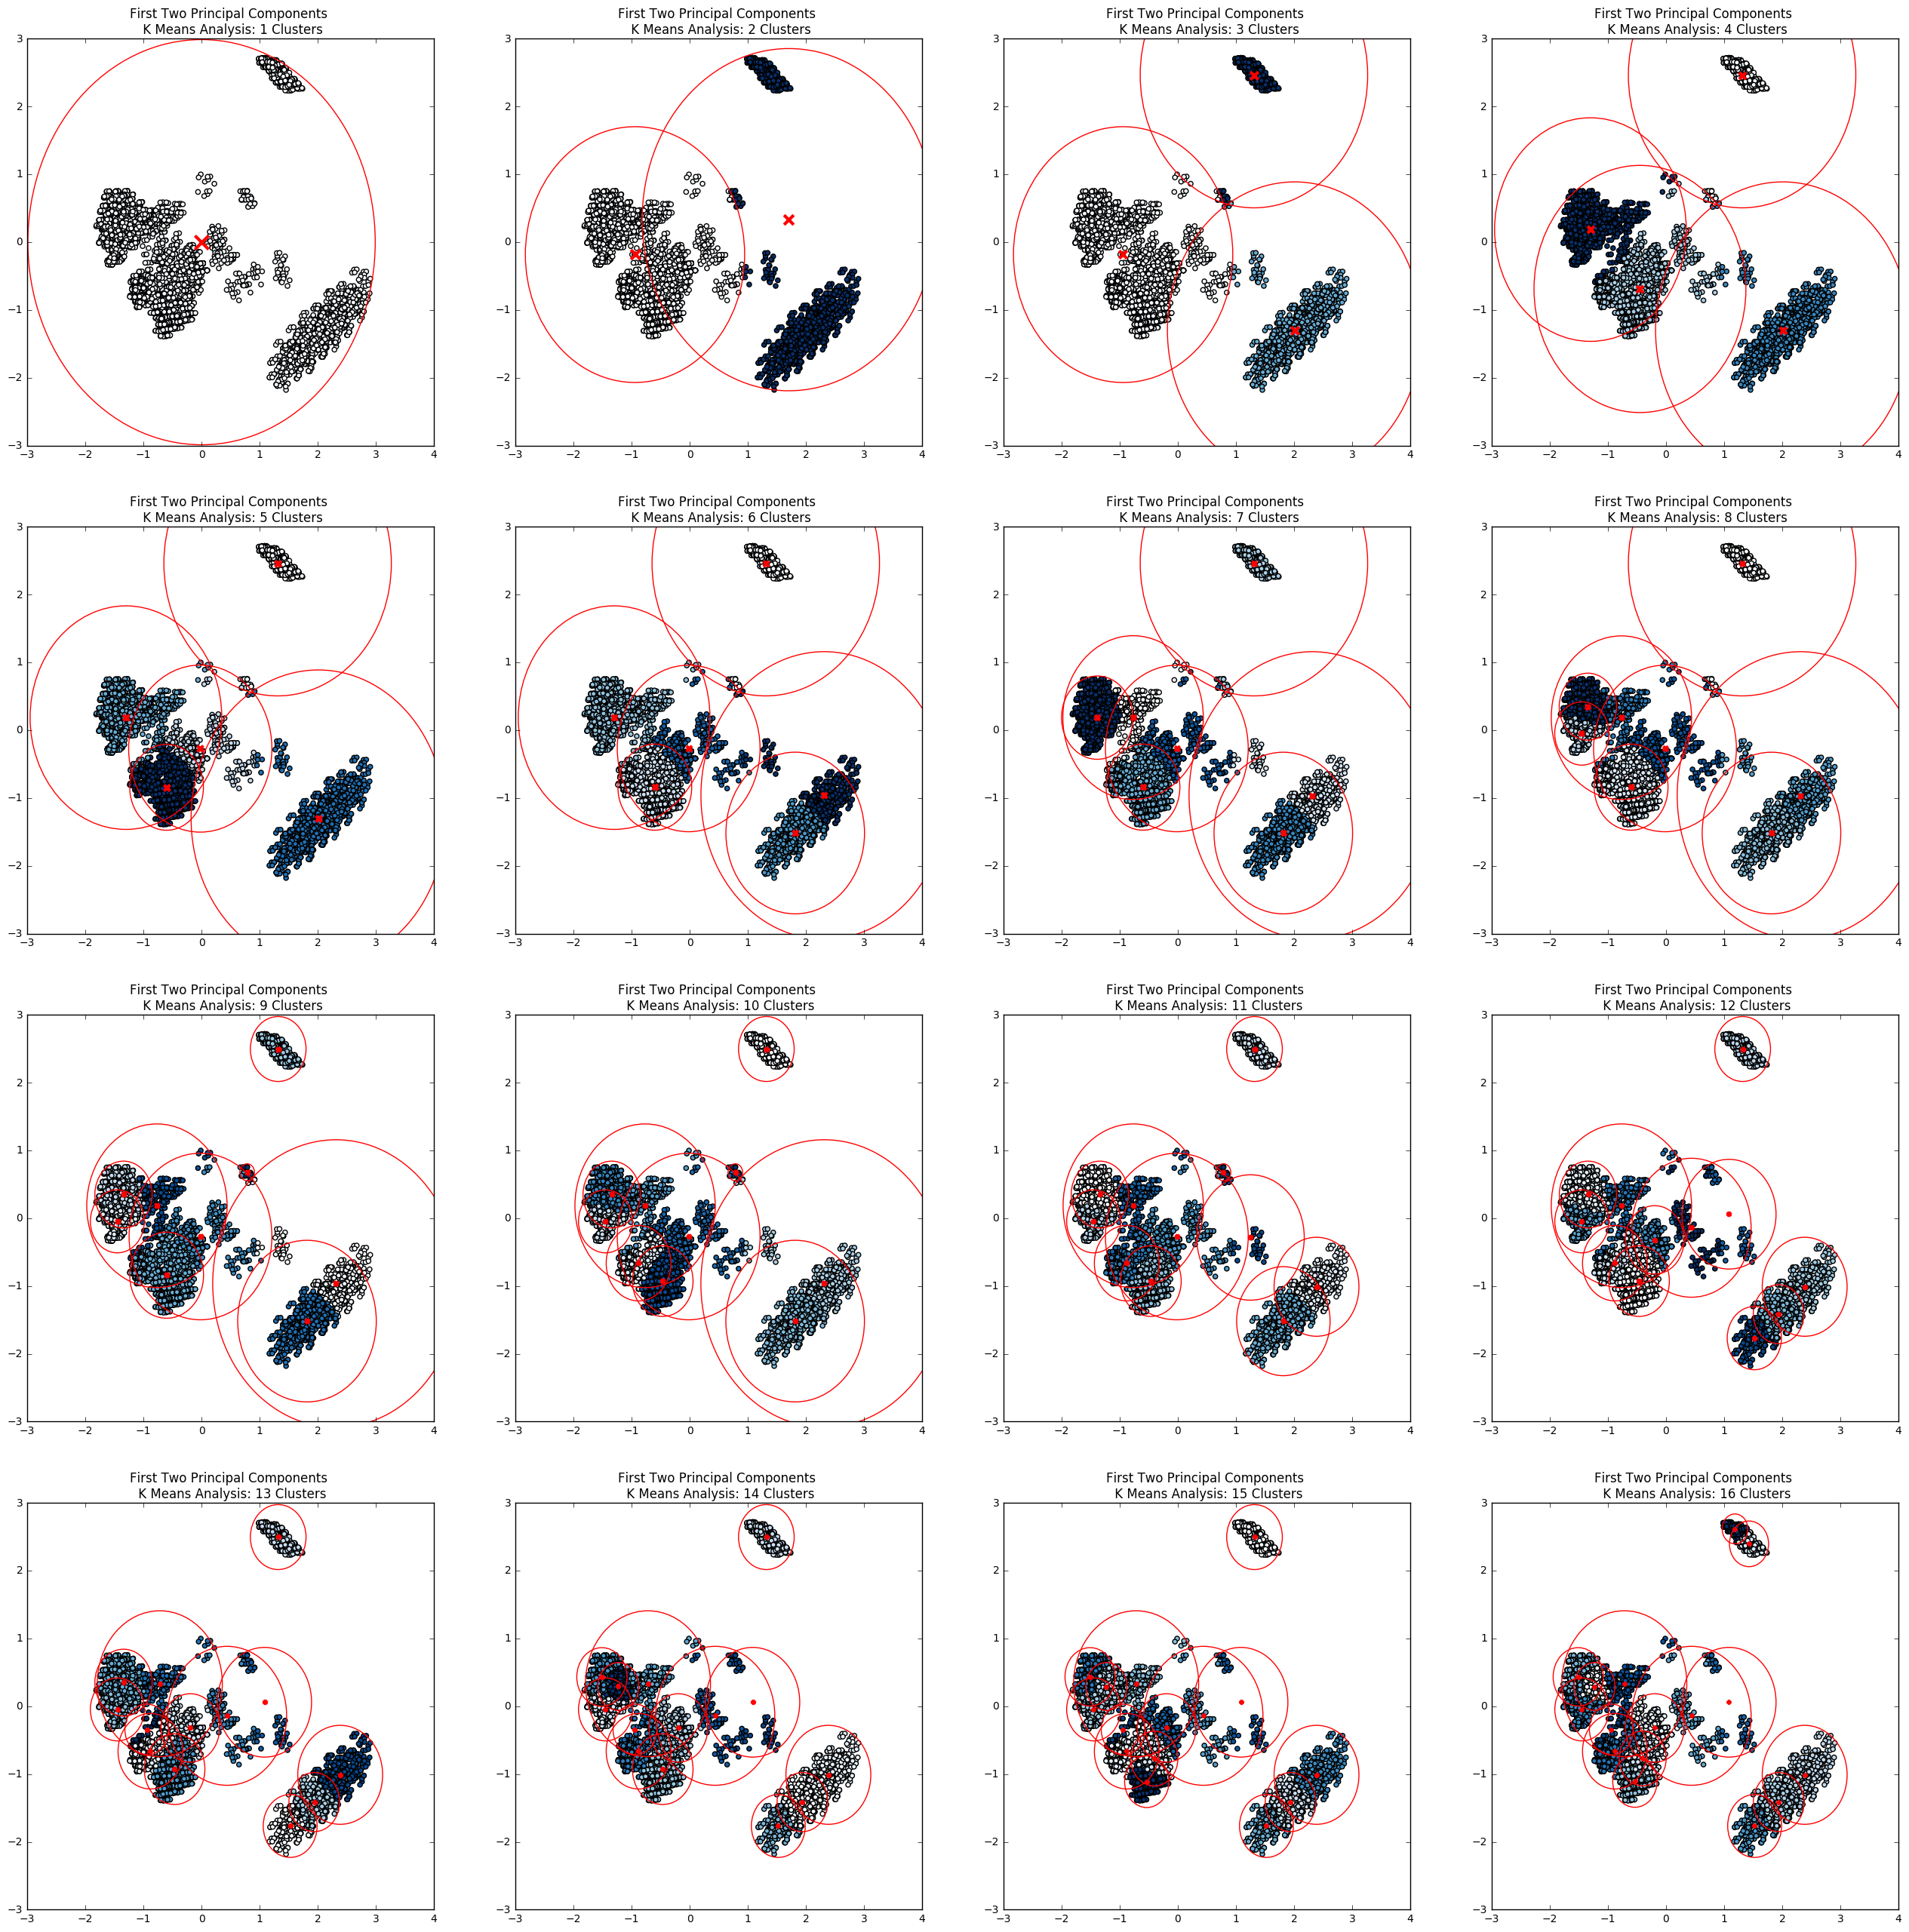

In [7]:
def P3():
### STUDENT START ###
    #get list of number of clusters to try
    n_clusters_to_try = np.arange(1, 17)

    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=False, sharey=False, figsize = (32, 32))

    #instantiate PCA object that reduces to 2 dimensions
    pca_2dim = PCA(n_components = 2)

    #transform the training data
    train_data_2dim_reduced = pd.DataFrame(pca_2dim.fit_transform(train_data))

    
    for n_clusters in n_clusters_to_try:

        #instantiate a K means classifier
        km = KMeans(n_clusters = n_clusters)

        #get the kmeans labels
        labels = km.fit_predict(train_data_2dim_reduced)

        #get centroids
        centroids = km.cluster_centers_

        #*********
        #Get distance of each point from its centroid
        train_data_2dim_reduced['kmeans_label'] = labels

        #put the centroid X and Y coordinates in columns in the dataframe
        train_data_2dim_reduced['Centroid_X'] = centroids[train_data_2dim_reduced['kmeans_label'],0]
        train_data_2dim_reduced['Centroid_Y'] = centroids[train_data_2dim_reduced['kmeans_label'],1]

        #calculate distance from each point to its centroid
        train_data_2dim_reduced['Centroid_dist'] = np.sqrt(\
                                                (train_data_2dim_reduced[0] - train_data_2dim_reduced['Centroid_X']) ** 2 \
                                                + (train_data_2dim_reduced[1] - train_data_2dim_reduced['Centroid_Y']) ** 2)

        #Get max dist for each centroid
        max_dist_by_centroid = train_data_2dim_reduced.groupby(by = 'kmeans_label', axis = 0)['Centroid_dist'].max()

        #Set color map
        cmap = cm.Blues

        #plot
        #fig2 = plt.figure()

        ax = fig.add_subplot(4, 4, n_clusters)

        plt.subplot(4,4,n_clusters)
        plt.title("First Two Principal Components \n K Means Analysis: " + str(n_clusters) + " Clusters")
        #Plot the data points in the 2-D PCA dimensionality reduced space
        plt.scatter(train_data_2dim_reduced[0], train_data_2dim_reduced[1], c = labels, cmap = cmap)
        #plot the centroids
        plt.scatter(centroids[:,0], centroids[:,1], marker = "x", color = "red", s = (169 / n_clusters), linewidths = 3)

        #plot circles around each centroid
        #will want to change radius to be the max distance from the centroid to any point in that cluster
        for i in range(n_clusters):
            circle = plt.Circle((centroids[i,0], centroids[i,1]), radius = max_dist_by_centroid[i],\
                                color = "red", fill = False)

            ax.add_artist(circle)

    plt.show()
### STUDENT END ###

P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

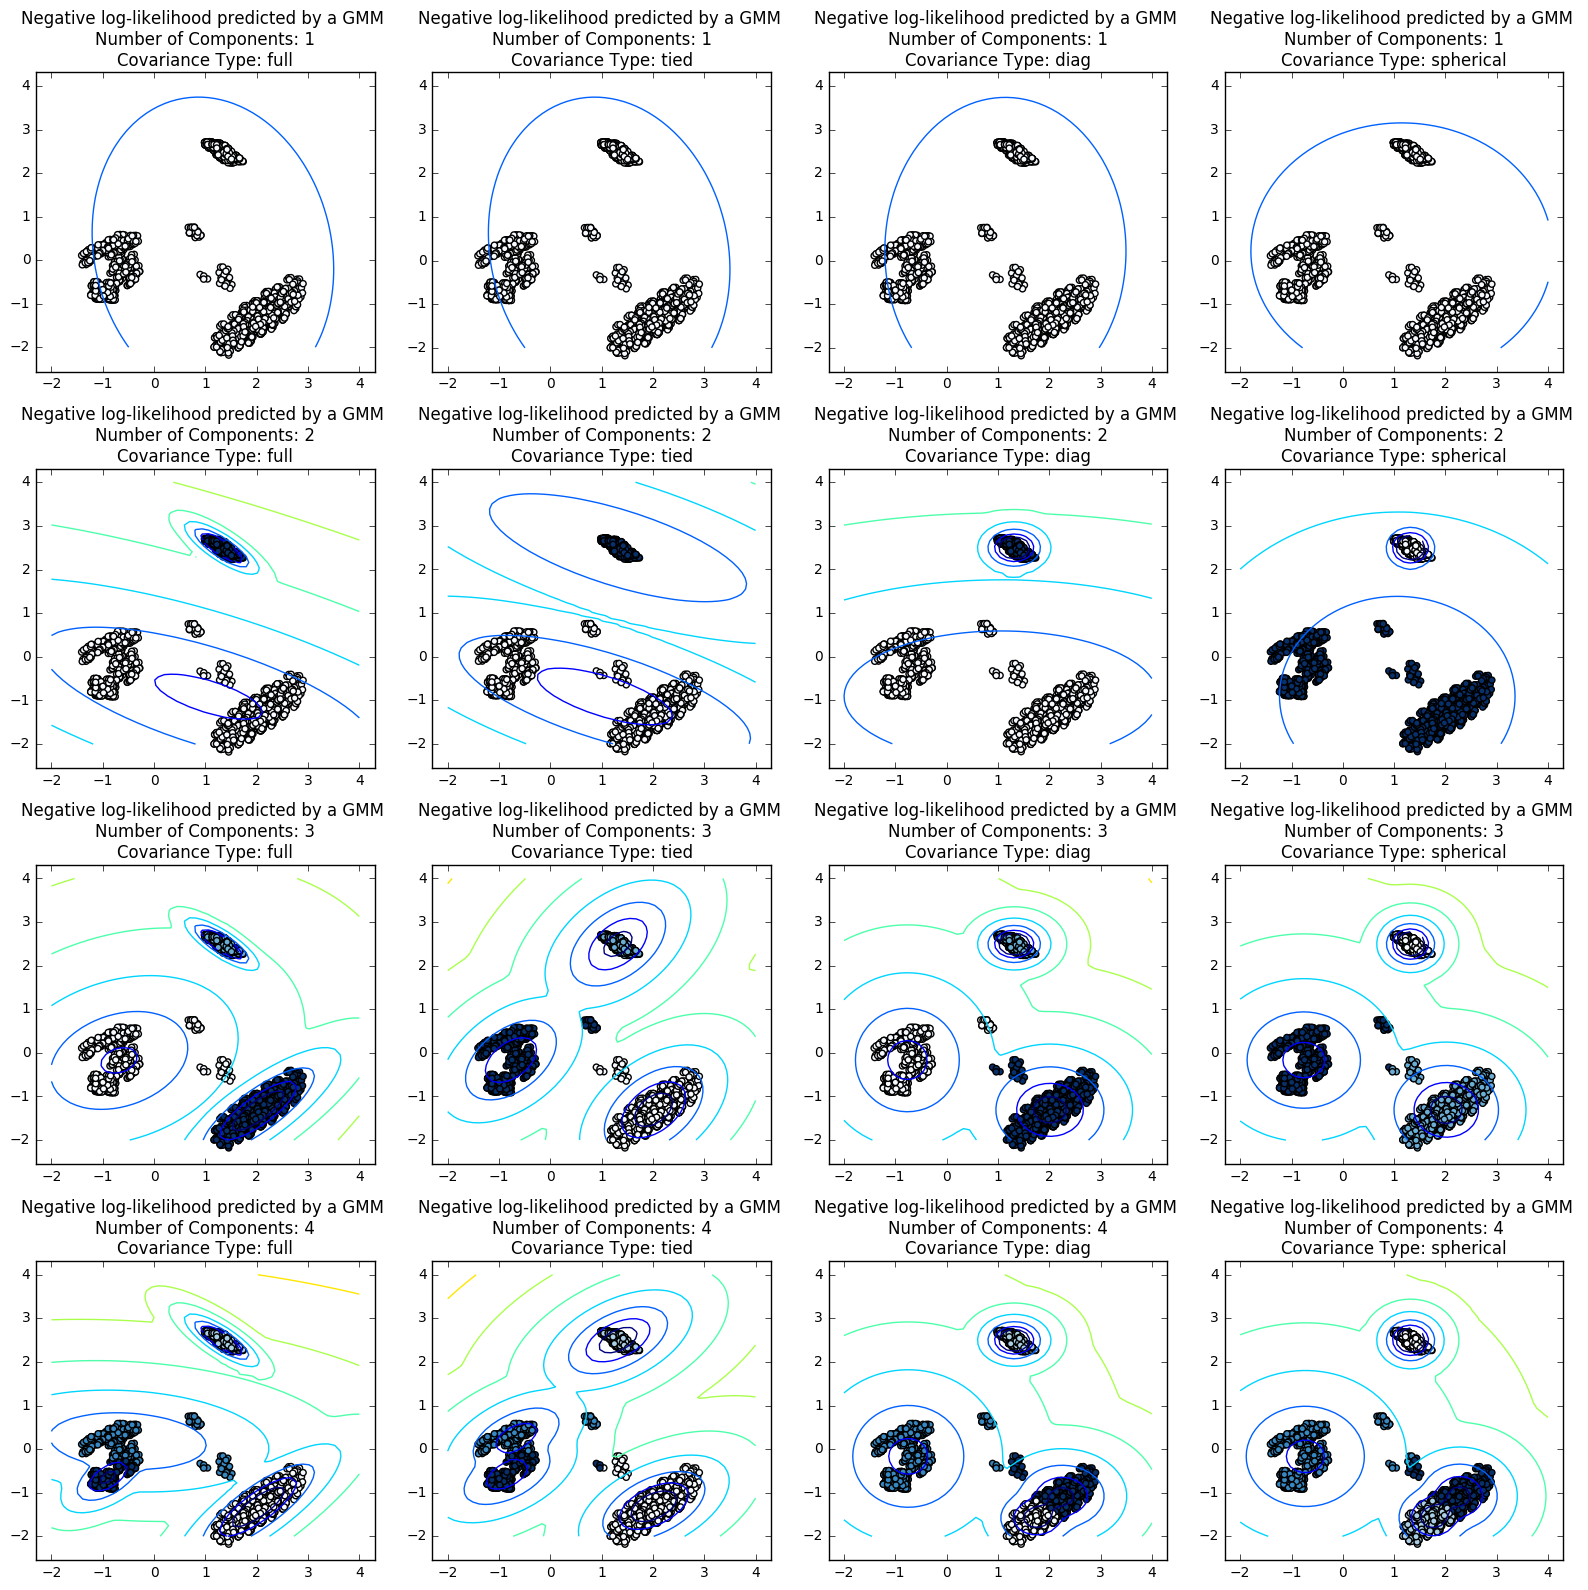

In [9]:
def P4():
    ### STUDENT START ###
    #instantiate PCA object that reduces to 2 dimensions
    pca_2dim = PCA(n_components = 2)

    #transform the training data
    train_data_2dim_reduced = pd.DataFrame(pca_2dim.fit_transform(train_data))

    #limit to positive examples
    train_data_2d_positive = train_data_2dim_reduced.loc[train_labels_df[0] == 1,:]

    #put covariance types in a list
    covariance_types = ['full', 'tied', 'diag', 'spherical']

    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=False, sharey=False, figsize = (16, 16))

    #Set color map
    cmap = cm.Blues

    #instantiate plot counter
    plot_counter = 1

    #Loop through number of components to try
    for n_components in np.arange(1, 5).tolist():

        #Loop through covariance types
        for i in range(4):

            #instantite the Gaussian mixture model classifier
            gm_mod = GaussianMixture(n_components = n_components, covariance_type = covariance_types[i])

            #fit the model
            gm_mod.fit(train_data_2d_positive)

            #generate predicted categories
            preds = gm_mod.predict(train_data_2d_positive)

            #add sub plot
            ax = fig.add_subplot(4, 4, plot_counter)

            plt.subplot(4, 4, plot_counter)

            # display predicted scores by the model as a contour plot
            x = np.linspace(-2., 4.)
            y = np.linspace(-2., 4.)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -gm_mod.score_samples(XX)
            Z = Z.reshape(X.shape)

            CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))

            #Plot the 2-D redued dimensionality data
            plt.scatter(train_data_2d_positive[0], train_data_2d_positive[1], c = preds, cmap = cmap)

            plt.title("Negative log-likelihood predicted by a GMM \nNumber of Components: "\
                      + str(n_components) + "\nCovariance Type: " + covariance_types[i])

            plt.tight_layout()

            #increment plot counter
            plot_counter += 1

    plt.show()
### STUDENT END ###

P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [113]:
def P5():
### STUDENT START ###
    #instantiate PCA object that reduces to 2 dimensions
    pca_2dim = PCA(n_components = 2)

    #transform the training data and the testing data
    train_data_2dim_reduced = pd.DataFrame(pca_2dim.fit_transform(train_data))
    test_data_2dim_reduced = pd.DataFrame(pca_2dim.fit_transform(test_data))

    #split data into positive and examples
    train_data_2d_positive = train_data_2dim_reduced.loc[train_labels_df[0] == 1,:]
    train_data_2d_negative = train_data_2dim_reduced.loc[train_labels_df[0] == 0,:]

    #Note, final accuracy is extremely sensitive to random state. In some random states, the accuracy is quity high(> 90 %)
    #but in others, the accuracy is worse than a coin flip)

    #Try numerous random states and take the average accuracy
    random_states_to_try = range(150)

    #instantiate an empty list to hold accuracies
    accuracy_results = []

    #Create a new classifier that fits two GMMs, one for the positive training examples and one for the negative examples
    class MyMushroomGMM(BaseEstimator, TransformerMixin):
    
        def __init__(self, n_components = 4, covariance_type = 'full', random_state = ''):
            self.covariance_type = covariance_type
            self.random_state = random_state
            self.n_components = n_components

        def fit(self,  train_data_pos, train_data_neg):       
            #instantiate the two classifiers
            self.GMM_pos = GaussianMixture(n_components = self.n_components,\
                                           covariance_type = self.covariance_type,\
                                           random_state = self.random_state)
            self.GMM_neg = GaussianMixture(n_components = self.n_components,\
                                           covariance_type = self.covariance_type,\
                                           random_state = self.random_state)

            #fit the positive and negative models to their respective examples
            self.GMM_pos.fit(train_data_pos)
            self.GMM_neg.fit(train_data_neg)

            return self

        def predict(self, X):
            #predict each example with both the positive and negative models
            preds_pos_df = pd.DataFrame(self.GMM_pos.score_samples(X), columns = ['pos_prob'])
            preds_neg_df = pd.DataFrame(self.GMM_neg.score_samples(X), columns = ['neg_prob'])

            #Predict the class with the highers max prob
            preds_combined = pd.concat([preds_pos_df, preds_neg_df], axis = 1)

            preds_combined['prediction'] = preds_combined.apply(lambda row: 1 if row['pos_prob'] > row['neg_prob'] else 0, axis = 1)

            return np.array( preds_combined['prediction'])

    #get accuracy for a variety of random seed values
    for state in random_states_to_try:
           
        #instantite mushroom GMM
        combined_model = MyMushroomGMM(random_state = state)
        
        #fit the model
        combined_model.fit(train_data_pos = train_data_2d_positive, train_data_neg = train_data_2d_negative)
        
        #get predictions
        preds_combined = pd.DataFrame(combined_model.predict(test_data_2dim_reduced), columns = ['prediction'])

        #add the actual category of the test data to the results dataframe
        preds_combined['actual_label'] = test_labels

        #Calculate accuracy
        accuracy = np.sum(preds_combined['actual_label'] == preds_combined['prediction']) / float(preds_combined.shape[0])

        
        #Append accuracy to results list
        accuracy_results.append(accuracy)

    print stats.describe(accuracy_results)
    
    #print accuracy_results
### STUDENT END ###

P5()

DescribeResult(nobs=150, minmax=(0.46263345195729538, 0.92882562277580072), mean=0.64239620403321473, variance=0.031535987083023756, skewness=0.7264248433458385, kurtosis=-1.2347718082176187)


The accuracy of this model is very dependent on the random state set when instantiating the model object. This is a reflection of the property of GMM that it is always guaranteed to converge, but not necessarily to a global minimum.

Generating predictions from 150 different random states yields a distribution of accuracies with a minimum accuracy of 0.463, a maximum accuracy of 0.929, a mean accuracy of 0.642 and a variance of 0.032.

(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [107]:
#First, create a new object that fits two separate GMM models for positive and negative examples
class MyMushroomGMM(BaseEstimator, TransformerMixin):

    def __init__(self, n_components = 4, covariance_type = 'full', random_state = ''):
        self.covariance_type = covariance_type
        self.random_state = random_state
        self.n_components = n_components

    def fit(self, train_data_pos, train_data_neg):       
        #instantiate the two classifiers
        self.GMM_pos = GaussianMixture(n_components = self.n_components,\
                                       covariance_type = self.covariance_type,\
                                       random_state = self.random_state)
        self.GMM_neg = GaussianMixture(n_components = self.n_components,\
                                       covariance_type = self.covariance_type,\
                                       random_state = self.random_state)

        #fit the positive and negative models to their respective examples
        self.GMM_pos.fit(train_data_pos)
        self.GMM_neg.fit(train_data_neg)

        return self

    def predict(self, X):
        #predict each example with both the positive and negative models
        preds_pos_df = pd.DataFrame(self.GMM_pos.score_samples(X), columns = ['pos_prob'])
        preds_neg_df = pd.DataFrame(self.GMM_neg.score_samples(X), columns = ['neg_prob'])

        #Predict the class with the highers max prob
        preds_combined = pd.concat([preds_pos_df, preds_neg_df], axis = 1)

        preds_combined['prediction'] = preds_combined.apply(lambda row: 1 if row['pos_prob'] > row['neg_prob'] else 0, axis = 1)

        return np.array( preds_combined['prediction'])

#Then create a pipeline that does PCA, fits the model to the training data, and predicts the testing data

# NOTE LEFT OFF HERE:

How to integrate PCA and model into pipeline because need to fit the model to a subset of the training data based on the labels. The issue here is that the pipeline needs to act differently if it is using the training data or the testing data.

In [144]:
#Write a custom PCA class that, for training examples will reduce the dimensionality of the positive and negative cases separately
#but for testing examples, will simply reduce the feature space of all examples together
class MyMushroomPCA(BaseEstimator, TransformerMixin):

    def __init__(self, n_components = 2, train_data = ''):
        self.n_components = n_components
        if train_data == '':
            raise ValueError('The flag train_data must be set to True or False')
        else:
            self.train_data = train_data

    def fit_transform(self, X, train_data = '', **kwargs):
        if train_data == '':
            raise ValueError('The flag train_data must be set to True or False')
        else:
            pass
        
        if 'y' in kwargs and train_data == True and kwargs['y'] is None:
            raise ValueError('When train_data is True, must also specify y labels')
        else:
            pass
        
        #transform y to df
        if train_data == True:
            y_df = pd.DataFrame(y)
        else:
            pass
        
        #instantiate a PCA classifier
        self.myPCA = PCA(n_components = self.n_components)
        
        #transform the data
        data_2dim_reduced = pd.DataFrame(self.myPCA.fit_transform(X))
        
        #if the data are training data, then split into positive and negative examples
        if self.train_data == True:
            data_2dim_reduced_pos = data_2dim_reduced.loc[y_df[0] == 1,:]
            data_2dim_reduced_neg = data_2dim_reduced.loc[y_df[0] == 0,:]
            
            return data_2dim_reduced_pos, data_2dim_reduced_neg
            
        else:
            return data_2dim_reduced

In [145]:
#Test the PCA class defined above
MyMushroomPCA_test = MyMushroomPCA(n_components = 2, train_data = True)

#test on the train data
train_data_2d_positive, train_data_2d_negative = MyMushroomPCA_test.fit_transform(X = train_data, y = train_labels, train_data = True)
train_data_2d_positive.head()

#test on the testing data
#test_data_2d_test = MyMushroomPCA_test.fit_transform(X = test_data, train_data = False)

#test_data_2d_test.head()


NameError: global name 'y' is not defined

In [117]:
#instantiate PCA object that reduces to 2 dimensions
pca_for_pipe = PCA(n_components = 2)
GMM_for_pipe = MyMushroomGMM()


#create pipeline that goes through from PCA through prediction of the test data
categorical_pipe = Pipeline(
    [("PCA", pca_for_pipe),
     ("GMM_model", GMM_for_pipe)]
)



In [110]:
#instantiate PCA object that reduces to 2 dimensions
pca_2dim = PCA(n_components = 2)

#transform the training data and the testing data
train_data_2dim_reduced = pd.DataFrame(pca_2dim.fit_transform(train_data))
test_data_2dim_reduced = pd.DataFrame(pca_2dim.fit_transform(test_data))

#split data into positive and examples
train_data_2d_positive = train_data_2dim_reduced.loc[train_labels_df[0] == 1,:]
train_data_2d_negative = train_data_2dim_reduced.loc[train_labels_df[0] == 0,:]

#instantiate classifier
test_classifier = MyMushroomGMM(covariance_type = 'tied', random_state = 148)
#test_classifier = MyMushroomGMM()

#fit the classifier to the training data
test_classifier.fit(train_data_pos = train_data_2d_positive, train_data_neg = train_data_2d_negative)

#generate predictions of the testing data
preds_df = pd.DataFrame(test_classifier.predict(test_data_2dim_reduced), columns = ['prediction'])

preds_df['actual_label'] = test_labels

#Calculate accuracy
accuracy = np.sum(preds_df['actual_label'] == preds_df['prediction']) / float(preds_df.shape[0])

display(preds_df.head())

print accuracy


,prediction,actual_label
0,1,0
1,1,0
2,1,0
3,0,1
4,1,0


0.678825622776


In [6]:
#def P6():
### STUDENT START ###

### STUDENT END ###

#P6()

In [70]:
np.array(preds_combined['prediction'])

array([1, 1, 1, ..., 0, 0, 1])